# Homework 2
**Instructions:**
- Submit your code to github by the deadline.
- DO NOT change paths (-3 points).
- DO NOT submit data to github (-2 points).

In [1]:
import numpy as np
import pandas as pd

## Problem 1: log loss
**(a)** You have a classification problem with 3 classes: "cat", "dog", "bird". For your test observation is a "dog". Your model give you the following prediction for that observation (0.1, 0.5, 0.4). What is the accuracy? What is the log loss?

**(b)** Suppose that you are submitting to a Kaggle competition. You are solving a binary classification task being evaluated by log loss metric. You suspect train and test target distributions are different, you submit a constant predition of 0.3 and to the public LB and get a score of 1.01. Mean of target variable in train is 0.44. What is the mean of target variable in public part of test data? Explain how you derive the results.

In [2]:
# (a)
pred = [0.1, 0.5, 0.4]
y = (np.array(["cat", "dog", "bird"])=="dog")
accuracy = np.all((np.array([pred]) == np.max(pred)) == y)
logLoss = -(y*np.log(pred)).sum()
int(accuracy), logLoss

(1, 0.69314718055994529)

(a)  
The accuracy is 1.  
The log loss is -log(0.5) = 0.69.  
(b)   
The $ \hat{y^{(i)}} $ is a constant: 0.3, and the score is the log loss of test data, 
so we have$$ -\frac{1}{m}\sum_{i=1}^{m}{y^{(i)}log(0.3)+ (1-y^{(i)})log(1-0.3)}=1.01, $$ where m is the number of observations in test data, thus $$ \bar{y}log(0.3)+ (1-\bar{y})log(1-0.3)=-1.01, $$
so $$ \bar{y} = 0.77$$


In [3]:
# (b)
logLoss = 1.01
pred = 0.3
y_bar = ( - logLoss - np.log(1 - pred))/np.log(pred/(1-pred))
y_bar

0.77106893172456137

## Problem 2: AUC
Compute AUC score by hand with the formula explained in class for the following dataset.

In [4]:
d = pd.DataFrame({
        'prediction': [0.1, 0.5, 0.95, 0.99, 0.8, 0.4, 0.03, 0.44, 0.2],
        'y': [1, 0, 1, 1, 1, 1, 0, 0, 0]})
d

,prediction,y
0,0.10,1
1,0.50,0
2,0.95,1
3,0.99,1
4,0.80,1
5,0.40,1
6,0.03,0
7,0.44,0
8,0.20,0


AUC is the probability a randomly-chosen positive example is ranked more highly than a randomly-chosen negative example. It can be computed as the ratio of

$$1 - \frac{\text{number of pairs example wrongly ordered }}{\text{number of pairs (positive, negative)}}$$

In [5]:
# YOUR CODE HERE
def get_auc(df):
    """
    num_ones = number of 1(s) till now
    num_wrong_pairs = number of wrong pairs
    for each 1 shows up, increase 'num_ones' by 1.
    for each 0 shows up, increase 'num_wrong_pairs' by 'num_ones'
    OMG!!! I am sooooooo smart!!! Hahahahahahh!!!
    """
    sorted_label = df.sort_values(['prediction'])['y']
    num_ones = 0
    num_zeros = 0
    num_wrong_pairs = 0
    try:
        for element in sorted_label:
            if element == 1:
                num_ones += 1
            elif element == 0:
                num_zeros += 1
                num_wrong_pairs += num_ones
        pairs = num_ones*num_zeros
    except:
        raise NotImplementedError()
        
    return 1 - num_wrong_pairs/pairs
get_auc(d)

0.75

## Problem 3: Regularized mean (target) encoding for Avazu competition

For this problem you will implement a version of regularized mean encoding. We will be using the data on this Kaggle [compettion](https://www.kaggle.com/c/avazu-ctr-prediction).  

**Instructions:**
- Split data (training) into training and validation. Take the last week (7 days) of training set as validation.
- Implement regularized mean encoding for the training set using pandas.
- Implement mean encoding for the validation set

In [6]:
## Split train and validation 
# get sample data first
path = "avazu/"
!head -100000 $path/train > $path/train_sample.csv
!head -100000 $path/test > $path/test_sample.csv
data = pd.read_csv(path + "train_sample.csv")
test = pd.read_csv(path + "test_sample.csv")

In [7]:
def split_based_hour(data):
    """ Split data based on column hour.
    
    Use 20% of the date for validation.
    Inputs:
       data: dataframe from avazu
    Returns:
       train:
       val: 20% of the largest values of column "hour".
    """
    N = int(0.8*len(data))
    data = data.sort_values(by="hour")
    train = data[:N].copy()
    val = data[N:].copy()
    return train.reset_index(), val.reset_index()
train, val = split_based_hour(data)

### Regularized mean encoding 
Here is how you do mean encoding without regularization.

In [8]:
# Calculate a mapping: {device_type: click_mean}
mean_device_type = train.groupby('device_type').click.mean()
mean_device_type

device_type
0    0.224277
1    0.176116
4    0.069777
5    0.083333
Name: click, dtype: float64

In [9]:
# This is the global click mean
global_mean = train.click.mean()
global_mean

0.17477718471480894

In [10]:
train["device_type_mean_enc"] = train["device_type"].map(mean_device_type)
val["device_type_mean_enc"] = val["device_type"].map(mean_device_type)

In [11]:
train["device_type_mean_enc"].fillna(global_mean, inplace=True)
val["device_type_mean_enc"].fillna(global_mean, inplace=True)

In [12]:
# Print correlation
encoded_feature = val["device_type_mean_enc"].values
print(np.corrcoef(val["click"].values, encoded_feature)[0][1])

0.0530389229998


To do mean encoding with K-fold regularization you do the following:

* Run a 5-fold split on train data where `mean_device_type` is computed on 4/5 of the data and the encoding is computed on the other 1/5.
* To compute mean encoding on the validation data use the code similar to encoding without regularization. That is compute on all the training data and apply to the validation set.

In [13]:
from sklearn.model_selection import KFold

def reg_target_encoding(train, col = "device_type", splits=5):
    """ Computes regularize mean encoding.
    Inputs:
       train: training dataframe
       
    """
    # YOUR CODE HERE
    try:
        kf = KFold(n_splits=5)
        X = train.copy()
        X[col + "_mean_enc"] = 0
        for train_index, val_index in kf.split(X):
            # get training statistics in X, and change in train
            mean_col = X.loc[train_index].groupby(col).click.mean()
            train.loc[val_index, col + "_mean_enc"] = train[col].map(mean_col)
        # validation set
        # mean_col = train.groupby(col + "_mean_enc").click.mean()
        # val[col + "_mean_enc"] = val[col].map(mean_col)
        # fill na
        global_mean = X.click.mean()
        train[col + "_mean_enc"].fillna(global_mean, inplace=True)
        # val[col + "_mean_enc"].fillna(global_mean, inplace=True)
    except:
        raise NotImplementedError()

In [14]:
reg_target_encoding(train) 
encoded_feature = train["device_type_mean_enc"].values
corr = np.corrcoef(train["click"].values, encoded_feature)[0][1]
assert(np.around(corr, decimals=4) == 0.0551)

In [15]:
def mean_encoding_test(test, train, col = "device_type"):
    """ Computes target enconding for test data.
    
    This is similar to how we do validation
    """
    # YOUR CODE HERE
    try:
        mean_col = train.groupby(col).click.mean()
        test[col + "_mean_enc"] = test[col].map(mean_col)
        # fill na
        global_mean = train.click.mean()
        test[col + "_mean_enc"].fillna(global_mean, inplace=True)
    except:
        raise NotImplementedError()

In [16]:
mean_encoding_test(test, train) 
encoded_feature_mean = test["device_type_mean_enc"].values.mean()
assert(np.around(encoded_feature_mean, decimals=4) == 0.177)

## Problem 4: Implement other features and fit a model (10 points)
* Implement a few more features, include:
   * day of the week and hour
   * mean encoding of some other features (at least two)
   * use plots and `value_counts()` to understand the data

* Fit a random forest (to the whole dataset)
   * Do hyperparameter tunning using your validation set
   * Report test and train log loss

In [ ]:
def load_data():
    path = "avazu/"
    data = pd.read_csv(path + "train")
    test = pd.read_csv(path + "test")
    return data, test

In [17]:
types = {'id': np.uint32, 'click': np.uint8, 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint32,
         'site_id': 'category', 'site_domain': 'category', 'site_category': 'category', 'app_id': 'category',
         'app_domain': 'category', 'app_category': 'category', 'device_id': 'category',
         'device_ip': 'category', 'device_model': 'category', 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}
path = "avazu/"
data = pd.read_csv(path + "train", usecols=types.keys(), dtype=types)
print(data.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
id                  uint32
click               uint8
hour                uint32
C1                  uint32
banner_pos          uint32
site_id             category
site_domain         category
site_category       category
app_id              category
app_domain          category
app_category        category
device_id           category
device_ip           category
device_model        category
device_type         uint8
device_conn_type    uint8
C14                 uint16
C15                 uint16
C16                 uint16
C17                 uint16
C18                 uint16
C19                 uint16
C20                 uint16
C21                 uint16
dtypes: category(9), uint16(8), uint32(4), uint8(3)
memory usage: 3.0 GB
None


In [18]:
types = {'id': np.uint64, 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint32,
         'site_id':'category', 'site_domain': 'category', 'site_category': 'category', 'app_id': 'category',
         'app_domain': 'category', 'app_category': 'category', 'device_id': 'category',
         'device_ip': 'category', 'device_model': 'category', 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}
test = pd.read_csv(path + "test", usecols=types.keys(), dtype=types)

In [19]:
test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000174058809263569,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,34539,23
1,10000182526920855428,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,34547,51
2,10000554139829213984,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,34547,51
3,10001094637809798845,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,1,0,18648,320,50,1092,3,809,34620,61
4,10001377041558670745,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,1,0,23160,320,50,2667,0,47,65535,221


In [20]:
import feather
import os
os.makedirs('tmp', exist_ok=True)
data.to_feather('tmp/data-original')
test.to_feather('tmp/test-original')

In [73]:
import feather
import os
data = pd.read_feather('tmp/data-original')
test = pd.read_feather('tmp/test-original')

In [74]:
def to_cat(col):
    data[col] = data[col].astype('category')
    mapper = dict([(cat, num) for (num, cat) in enumerate(data[col].cat.categories)])
    data[col] = data[col].cat.codes 
    test[col] = test[col].map(mapper)
    test[col] = test[col].fillna(-1)

In [75]:
to_cat("site_id")
to_cat("site_domain")
to_cat("site_category")
to_cat("app_id")
to_cat("app_domain")
to_cat("app_category")
to_cat("device_id")
to_cat("device_ip")
to_cat("device_model")
to_cat("device_type")    
to_cat("device_conn_type")

In [76]:
def dow_hour(df):
    dayhour = '20' + df['hour'].astype(str)
    day = dayhour.str.slice(0,8)
    df['hour'] = dayhour.str.slice(8,10).astype(int)
    df['date'] = pd.to_datetime(day, format = '%Y%m%d')
    df['dow'] = df['date'].dt.dayofweek
dow_hour(data)
dow_hour(test)

In [77]:
data['date'].value_counts()

2014-10-22    5337126
2014-10-28    5287222
2014-10-30    4218938
2014-10-21    4122995
2014-10-23    3870752
2014-10-26    3835892
2014-10-29    3832608
2014-10-25    3363122
2014-10-24    3335302
2014-10-27    3225010
Name: date, dtype: int64

In [78]:
def split_based_date(data):
    """ Split data based on column date.
    
    Use last date for validation.
    Inputs:
       data: dataframe from avazu
    Returns:
       train: 
       val: data of date 2014-10-27
    """
    train = data[data['date'] != '2014-10-27']
    val = data[data['date'] == '2014-10-27']
    return train.reset_index(), val.reset_index()
train, val = split_based_date(data)

In [79]:
import feather
import os
os.makedirs('tmp', exist_ok=True)
data.to_feather('tmp/data-raw')
train.to_feather('tmp/train-raw')
val.to_feather('tmp/val-raw')
test.to_feather('tmp/test-raw')

In [1]:
import feather
import os
import pandas as pd
train = pd.read_feather('tmp/train-raw')
val = pd.read_feather('tmp/val-raw')
test = pd.read_feather('tmp/test-raw')

In [13]:
reg_target_encoding(train, col = "device_type")
mean_encoding_test(val, train, col = "device_type")

In [14]:
train['click'].groupby(train["banner_pos"]).mean()

banner_pos
0    0.163238
1    0.182487
2    0.118195
3    0.196576
4    0.188252
5    0.121196
7    0.333014
Name: click, dtype: float64

In [15]:
reg_target_encoding(train, col = "banner_pos")
mean_encoding_test(val, train, col = "banner_pos") 

In [16]:
train['click'].groupby(train["hour"]).mean()

hour
0     0.180255
1     0.183698
2     0.175544
3     0.174288
4     0.157549
5     0.161102
6     0.166527
7     0.178165
8     0.161525
9     0.158023
10    0.160605
11    0.170740
12    0.170461
13    0.166377
14    0.175351
15    0.180172
16    0.178087
17    0.172407
18    0.168420
19    0.163511
20    0.160731
21    0.160944
22    0.163969
23    0.171064
Name: click, dtype: float64

In [17]:
reg_target_encoding(train, col = "hour")
mean_encoding_test(val, train, col = "hour") 

In [19]:
print(train.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37203957 entries, 0 to 37203956
Data columns (total 30 columns):
index                   int64
id                      uint32
click                   uint8
hour                    int64
C1                      uint32
banner_pos              uint32
site_id                 int16
site_domain             int16
site_category           int8
app_id                  int16
app_domain              int16
app_category            int8
device_id               int32
device_ip               int32
device_model            int16
device_type             int8
device_conn_type        int8
C14                     uint16
C15                     uint16
C16                     uint16
C17                     uint16
C18                     uint16
C19                     uint16
C20                     uint16
C21                     uint16
date                    datetime64[ns]
dow                     int64
device_type_mean_enc    float64
banner_pos_mean_enc     flo

In [20]:
reg_target_encoding(train, col = 'site_category')
mean_encoding_test(val, train, col = 'site_category') 

In [21]:
reg_target_encoding(train, col = 'app_category')
mean_encoding_test(val, train, col = 'app_category')

In [22]:
import feather
import os
os.makedirs('tmp', exist_ok=True)
train.to_feather('tmp/train-encoding')
val.to_feather('tmp/val-encoding')

In [3]:
import feather
import os
os.makedirs('tmp', exist_ok=True)
train = pd.read_feather('tmp/train-encoding')
val = pd.read_feather('tmp/val-encoding')

plot and value_counts

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:66: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ec2-user/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


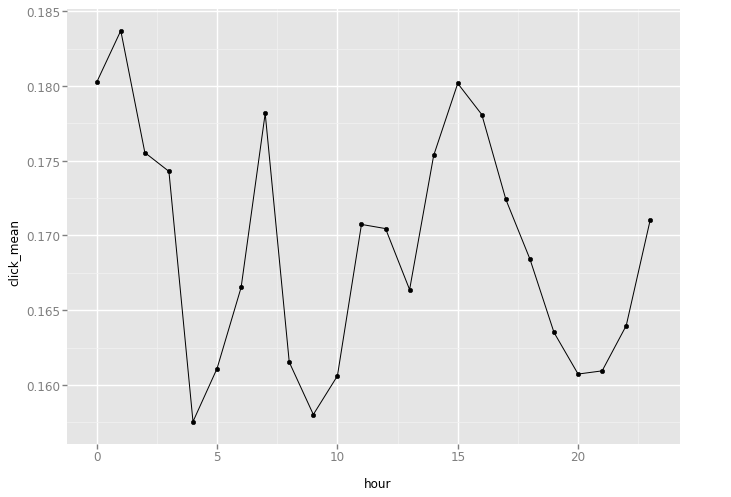

<ggplot: (8749587878685)>

In [4]:
from ggplot import *
df = pd.DataFrame({'click_mean' : train["click"].groupby(train["hour"]).mean()}).reset_index()
ggplot(df, aes(x = 'hour', y = 'click_mean'))+ geom_line() + geom_point()

In [5]:
click0 = train[train['click'] == 0]['hour'].value_counts()
click1 = train[train['click'] == 1]['hour'].value_counts()
df = pd.DataFrame({'click0':click0,'click1':click1, 'hour':range(1,25)})

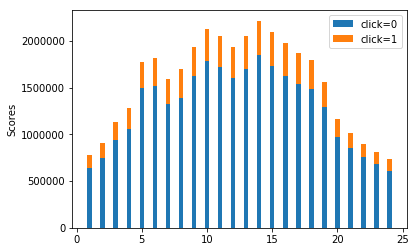

In [6]:
import numpy as np
import matplotlib.pyplot as plt

width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(df['hour'], df['click0'], width)
p2 = plt.bar(df['hour'], df['click1'], width,
             bottom=df['click0'])

plt.ylabel('Scores')
plt.legend((p1[0], p2[0]), ('click=0', 'click=1'))

plt.show()

In [7]:
train.device_type.value_counts()

1    34508829
0     1864799
3      711752
4      118546
2          31
Name: device_type, dtype: int64

In [8]:
train['date'].value_counts()

2014-10-22    5337126
2014-10-28    5287222
2014-10-30    4218938
2014-10-21    4122995
2014-10-23    3870752
2014-10-26    3835892
2014-10-29    3832608
2014-10-25    3363122
2014-10-24    3335302
Name: date, dtype: int64

In [9]:
train['date'].value_counts()

2014-10-22    5337126
2014-10-28    5287222
2014-10-30    4218938
2014-10-21    4122995
2014-10-23    3870752
2014-10-26    3835892
2014-10-29    3832608
2014-10-25    3363122
2014-10-24    3335302
Name: date, dtype: int64

In [10]:
train['hour'].value_counts()

13    2215678
9     2124335
14    2098341
12    2050354
10    2048514
15    1977180
11    1933751
8     1932710
16    1870769
5     1813637
17    1795375
4     1776664
7     1695369
6     1590226
18    1556107
3     1278455
19    1160263
2     1136844
20    1013056
1      909402
21     899716
22     812723
0      782924
23     731564
Name: hour, dtype: int64

In [11]:
train['banner_pos'].value_counts()

0    26716283
1    10424872
7       36545
2       12031
4        6895
5        5520
3        1811
Name: banner_pos, dtype: int64

In [12]:
train['app_category'].value_counts()

0     23957514
4      8802467
29     1621855
21     1389242
34     1088417
30      118377
1        53616
31       53373
17       37991
35       20075
11       19537
20       12026
23       10282
9         5969
5         5043
25        2340
7         2134
22        1541
18         552
2          408
24         337
15         250
8          207
6          204
13         131
3           25
10          16
27           9
16           5
26           4
19           3
14           2
32           2
12           1
28           1
33           1
Name: app_category, dtype: int64

In [13]:
train['C1'].value_counts()

1005    34368811
1002     1864799
1010      830298
1012       92653
1007       32980
1001        8887
1008        5529
Name: C1, dtype: int64

In [14]:
train['C15'].value_counts()

320     34769910
300      2061005
216       293976
728        70659
120         2504
1024        2366
480         1994
768         1543
Name: C15, dtype: int64

In [15]:
train['C16'].value_counts()

50      35129245
250      1609387
36        293976
480        92283
90         70659
20          2504
768         2366
320         1994
1024        1543
Name: C16, dtype: int64

In [16]:
train['C18'].value_counts()

0    15921374
3    12538369
2     6385355
1     2358859
Name: C18, dtype: int64

In [17]:
train["dow"].value_counts()

1    9410217
2    9169734
3    8089690
6    3835892
5    3363122
4    3335302
Name: dow, dtype: int64

In [27]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [28]:
from sklearn.metrics import log_loss
def print_score(m):
    res = [log_loss(y_train, m.predict(X_train)), log_loss(y_val, m.predict(X_val)),
                m.score(X_train, y_train), m.score(X_val, y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [43]:
X_train = train.drop(['click', 'id', 'index', 'date', 'device_type', 'banner_pos', 'hour', 'site_category', 'app_category'], axis=1)
y_train = train['click']
X_val = val.drop(['click', 'id', 'index', 'date', 'device_type', 'banner_pos', 'hour', 'site_category', 'app_category'], axis=1)
y_val = val['click']

In [44]:
set_rf_samples(50000)
m = RandomForestRegressor(n_estimators=10, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)

In [45]:
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [46]:
print_score(m)

[0.56763837902467085, 0.68713599443942475, 0.059852876784267317, 0.0037001667569692698, 0.058464037737584129]


In [47]:
fi = rf_feat_importance(m, X_train)
fi

,cols,imp
6,device_ip,0.205649
7,device_model,0.147436
20,hour_mean_enc,0.133708
9,C14,0.077286
15,C20,0.043175
1,site_id,0.039036
2,site_domain,0.035762
17,dow,0.035695
22,app_category_mean_enc,0.035158
16,C21,0.029765


In [48]:
keep = fi[fi['imp']>0.01].cols

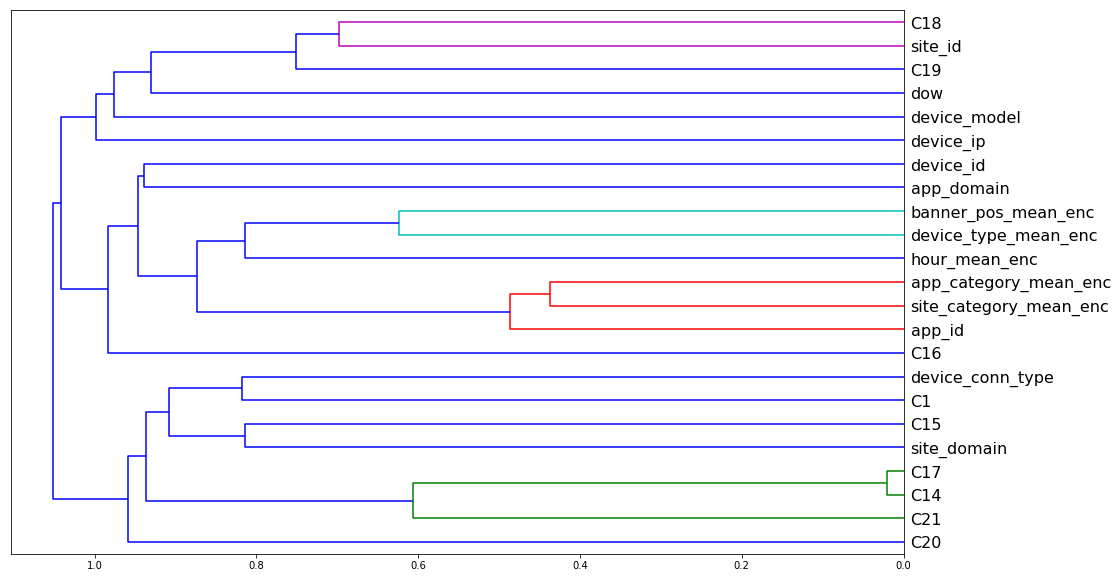

In [49]:
from scipy.cluster import hierarchy as hc
import scipy
import matplotlib.pyplot as plt
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [50]:
# drop non_importance columns and C17
X_train = X_train[keep].drop('C17', axis = 1)
X_val = X_val[keep].drop('C17', axis = 1)

In [51]:
import feather
import os
os.makedirs('tmp', exist_ok=True)
X_train.to_feather('tmp/X_train-final')
X_val.to_feather('tmp/X_val-final')

In [52]:
import feather
import os
os.makedirs('tmp', exist_ok=True)
X_train = pd.read_feather('tmp/X_train-final')
X_val = pd.read_feather('tmp/X_val-final')

In [57]:
hyper_tune = pd.DataFrame({'max_features': np.zeros(30), 'max_depth': np.zeros(30), 'val_logLoss': np.zeros(30)})
m = RandomForestRegressor(n_estimators=10, min_samples_leaf=10, n_jobs=-1, oob_score=True)
m.set_params(max_features = 0.5)
m.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [58]:
hyper_tune.iloc[0] = feature_num, depth_num, log_loss(y_val, m.predict(X_val))

In [59]:
# tune max_features in [0.5, 'sqrt', 'log2']
# tune max_depth from 10 to 20
hyper_tune = pd.DataFrame({'max_features': np.zeros(30), 'max_depth': np.zeros(30), 'val_logLoss': np.zeros(30)})
m = RandomForestRegressor(n_estimators=10, min_samples_leaf=10, n_jobs=-1, oob_score=True)
i = 0
for feature_num in [0.5, 'sqrt', 'log2']:
    m.set_params(max_features = feature_num)
    for depth_num in range(10,20):
        m.set_params(max_depth = depth_num)
        m.fit(X_train, y_train)
        hyper_tune.iloc[i] = feature_num, depth_num, log_loss(y_val, m.predict(X_val))
        i += 1

In [63]:
sort_hyper_tune = hyper_tune.sort_values(by = 'val_logLoss', ascending = True)

In [65]:
# the column order was wrong
correct_sort_hyper_tune = pd.DataFrame({'max_depth':sort_hyper_tune['max_features'], 
                                        'max_features': sort_hyper_tune['max_depth'], 
                                       'val_logLoss': sort_hyper_tune['val_logLoss']})
correct_sort_hyper_tune

,max_depth,max_features,val_logLoss
20,10.0,log2,0.448219
24,14.0,log2,0.451661
22,12.0,log2,0.453876
14,14.0,sqrt,0.454342
3,13.0,0.5,0.454483
13,13.0,sqrt,0.454654
4,14.0,0.5,0.455315
0,10.0,0.5,0.456810
10,10.0,sqrt,0.457341
8,18.0,0.5,0.458582


In [62]:
sort_hyper_tune = hyper_tune.to_csv("hyper_tune.csv", index = False)

train with the whole dataset 

In [17]:
# data after label encoding and extracting date and hour
data = pd.read_feather('tmp/data-raw')
test = pd.read_feather('tmp/test-raw')

In [18]:
reg_target_encoding(data, col = "device_type")
mean_encoding_test(test, data, col = "device_type")

reg_target_encoding(data, col = "banner_pos")
mean_encoding_test(test, data, col = "banner_pos") 

reg_target_encoding(data, col = "hour")
mean_encoding_test(test, data, col = "hour") 

reg_target_encoding(data, col = 'site_category')
mean_encoding_test(test, train, col = 'site_category') 

reg_target_encoding(data, col = 'app_category')
mean_encoding_test(test, data, col = 'app_category')

In [24]:
final_keep = ['device_ip', 'device_model', 'hour_mean_enc', 'C14', 'C20', 'site_id', 'site_domain', 'dow', 
        'app_category_mean_enc', 'C21', 'site_category_mean_enc', 'C16', 'device_id', 'C17', 'banner_pos_mean_enc',
             'C19', 'app_id', 'device_type_mean_enc']
X_data = data[final_keep].drop('C17', axis = 1)
y_data = data['click']
X_test = test[final_keep].drop('C17', axis = 1)

In [29]:
# set max_features='log2', max_depth = 10
set_rf_samples(100000)
m = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10, max_features='log2', max_depth = 10,
                          n_jobs=-1, oob_score=True)

In [30]:
m.fit(X_data, y_data)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [31]:
y_test = m.predict(X_test)

In [32]:
pred = pd.DataFrame({'id': test['id'], 'click' : y_test})

In [33]:
pred.to_csv("pred.csv", index = False)

The log loss given by kaggle late submission is 0.4141195